# 1. MỞ ĐẦU
Chỉ số chất lượng không khí (Air Quality Index – AQI) là một trong những chỉ số môi trường quan trọng, phản ánh mức độ ô nhiễm không khí và tác động tiềm tàng đến sức khỏe con người. Ở Việt Nam, với tốc độ đô thị hóa nhanh chóng, sự gia tăng dân số và phương tiện giao thông cơ giới, chất lượng không khí tại các thành phố lớn đang có xu hướng suy giảm nghiêm trọng.

Theo Tổ chức Y tế Thế giới (WHO), việc tiếp xúc lâu dài với không khí ô nhiễm là nguyên nhân dẫn đến các bệnh về đường hô hấp như viêm phế quản mãn tính, hen suyễn, thậm chí là ung thư phổi. Đặc biệt, các nhóm đối tượng nhạy cảm như người già, trẻ em và người mắc bệnh mãn tính chịu ảnh hưởng rõ rệt hơn trước sự biến động của chỉ số AQI.

Việc theo dõi và phân tích dữ liệu AQI không chỉ nhằm đánh giá hiện trạng ô nhiễm mà còn giúp phát hiện các quy luật theo thời gian (ngày – giờ), không gian (khu vực – thành phố) và điều kiện môi trường (thời tiết). Thông qua đó, cơ quan chức năng có thể:

Thiết lập các cơ chế cảnh báo kịp thời cho người dân,

Tối ưu hóa quy hoạch đô thị và điều chỉnh chính sách môi trường,

Khuyến nghị về thời điểm phù hợp để tổ chức các hoạt động ngoài trời, đặc biệt đối với trường học, bệnh viện và khu vực đông dân cư.

Với mục tiêu đó, báo cáo này tiến hành phân tích chuyên sâu dữ liệu AQI tại một số tỉnh/thành phố tiêu biểu của Việt Nam, từ đó đề xuất các nhận định mang tính thực tiễn và định hướng ứng dụng.

# import thư viện cần thiết

# 2. PHÂN TÍCH BIẾN ĐỘNG CHẤT LƯỢNG KHÔNG KHÍ THEO THỜI GIAN

# 2.1 Phân tích thống kê AQI (mean, max, min) theo tháng và tỉnh – Nhận diện xu hướng ô nhiễm theo thời gian
Mục tiêu phân tích
Phân tích AQI trung bình theo từng tháng giúp đánh giá mức độ ô nhiễm không khí biến động như thế nào trong khoảng thời gian dài (từ tháng 1 đến tháng 8/2025). Mục tiêu là:

Nhận diện thành phố có chất lượng không khí kém hoặc bất ổn kéo dài.

Xác định các khoảng thời gian có AQI tăng đột biến để điều tra nguyên nhân hoặc cảnh báo cộng đồng.

In [45]:
# ==== A. THỐNG KÊ MEAN/MAX/MIN THEO THÁNG & TỈNH ====
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# --- Đường dẫn (notebook nằm trong detection/):
DATA_DIR = Path("../data").resolve()
OUT_SUMMARY_DIR = Path("../result_summary").resolve()
OUT_PLOTS_DIR   = Path("../out/plots").resolve()
OUT_SUMMARY_DIR.mkdir(parents=True, exist_ok=True)
OUT_PLOTS_DIR.mkdir(parents=True, exist_ok=True)

def load_all_cities_from_data(root: Path):
    """Đọc tất cả CSV trong data/<city>/*.csv, giữ 3 cột: timestamp, city, aqi"""
    dfs = []
    for city_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        for f in sorted(city_dir.glob("*.csv")):
            try:
                df = pd.read_csv(f)
            except Exception as e:
                print(f"[!] Lỗi đọc {f}: {e}")
                continue

            # Chuẩn cột
            if "AQI" in df.columns and "aqi" not in df.columns:
                df.rename(columns={"AQI": "aqi"}, inplace=True)

            need = [c for c in ["timestamp", "city", "aqi"] if c not in df.columns]
            if need:
                print(f"[!] Bỏ qua {f.name} (thiếu {need})")
                continue

            df = df[["timestamp", "city", "aqi"]].copy()
            df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
            df["aqi"] = pd.to_numeric(df["aqi"], errors="coerce")
            df = df.dropna(subset=["timestamp", "aqi"])
            dfs.append(df)

    if not dfs:
        raise RuntimeError("Không có dữ liệu hợp lệ trong data/*/*.csv")

    return pd.concat(dfs, ignore_index=True)

def monthly_summary(df: pd.DataFrame):
    df["month"] = df["timestamp"].dt.to_period("M").astype(str)
    g = (
        df.groupby(["city", "month"])["aqi"]
          .agg(mean_aqi="mean", max_aqi="max", min_aqi="min", n_obs="size")
          .reset_index()
          .sort_values(["city", "month"])
    )
    g["mean_aqi"] = g["mean_aqi"].round(2)
    return g

def plot_mean_trend(stats: pd.DataFrame, out_dir: Path):
    pivot = stats.pivot(index="month", columns="city", values="mean_aqi").sort_index()
    plt.figure(figsize=(12,5))
    pivot.plot(marker="o")
    plt.title("Xu hướng AQI trung bình theo tháng (tất cả tỉnh)")
    plt.xlabel("Tháng (YYYY-MM)")
    plt.ylabel("AQI trung bình")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(out_dir / "trend_mean_all_cities.png", dpi=150)
    plt.close()

# ---- RUN
print("[i] Đang đọc data…", DATA_DIR)
df_all = load_all_cities_from_data(DATA_DIR)
stats = monthly_summary(df_all)

# Lưu & preview
stats_path = OUT_SUMMARY_DIR / "aqi_monthly_summary.csv"
stats.to_csv(stats_path, index=False, encoding="utf-8-sig")
print("[✓] Ghi:", stats_path)
print(stats.head(10).to_string(index=False))

# Vẽ biểu đồ gộp
plot_mean_trend(stats, OUT_PLOTS_DIR)
print("[✓] Đã vẽ:", OUT_PLOTS_DIR / "trend_mean_all_cities.png")


[i] Đang đọc data… C:\xampp\htdocs\Automatic-Anomaly-Detection-System\data


C:\Users\HP\AppData\Local\Temp\ipykernel_3196\4162367236.py:45: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["timestamp"].dt.to_period("M").astype(str)


[✓] Ghi: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\result_summary\aqi_monthly_summary.csv
   city   month  mean_aqi  max_aqi  min_aqi  n_obs
Cần Thơ 2025-01     74.92      138       60    243
Cần Thơ 2025-02     71.98      138       28    663
Cần Thơ 2025-03     71.32      118       52    731
Cần Thơ 2025-04     79.88      162       32    709
Cần Thơ 2025-05     69.05      153        6    741
Cần Thơ 2025-06     47.43      153        0    698
Cần Thơ 2025-07     50.30       94       11    711
Cần Thơ 2025-08     35.31       69        6    113
    Huế 2025-01     72.19      138       22    242
    Huế 2025-02     50.88      124       26    665
[✓] Đã vẽ: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\trend_mean_all_cities.png


<Figure size 1200x500 with 0 Axes>

# 2.2 Trung bình AQI theo giờ – Nhận diện thời điểm ô nhiễm cao trong ngày
Mục tiêu phân tích
Việc theo dõi chỉ số AQI theo giờ giúp:

Xác định khung giờ nguy hiểm (AQI cao bất thường) trong ngày.

Đưa ra khuyến cáo thời điểm hạn chế hoạt động ngoài trời hoặc tăng cường kiểm soát giao thông, sản xuất.

In [48]:
# ==== C. TRUNG BÌNH AQI THEO GIỜ ====

def hourly_summary(df: pd.DataFrame):
    df["hour"] = df["timestamp"].dt.hour
    g = (
        df.groupby(["city", "hour"])["aqi"]
          .mean()
          .reset_index()
          .rename(columns={"aqi": "mean_aqi"})
    )
    g["mean_aqi"] = g["mean_aqi"].round(2)
    return g

def plot_hourly_mean(stats: pd.DataFrame, out_dir: Path):
    pivot = stats.pivot(index="hour", columns="city", values="mean_aqi").sort_index()

    # Biểu đồ gộp tất cả tỉnh
    plt.figure(figsize=(12, 5))
    pivot.plot(marker="o")
    plt.title("Trung bình AQI theo giờ (tất cả tỉnh)")
    plt.xlabel("Giờ trong ngày (0-23)")
    plt.ylabel("AQI trung bình")
    plt.xticks(range(0,24))
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(out_dir / "hourly_mean_all_cities.png", dpi=150)
    plt.close()
    print("[✓] Đã lưu:", out_dir / "hourly_mean_all_cities.png")

    # Biểu đồ riêng từng tỉnh
    for city in sorted(stats["city"].unique()):
        sub = stats[stats["city"] == city].sort_values("hour")
        plt.figure(figsize=(10,4))
        plt.plot(sub["hour"], sub["mean_aqi"], marker="o")
        plt.title(f"Trung bình AQI theo giờ – {city}")
        plt.xlabel("Giờ (0-23)")
        plt.ylabel("AQI trung bình")
        plt.xticks(range(0,24))
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        out_file = out_dir / f"hourly_mean_{city}.png"
        plt.savefig(out_file, dpi=150)
        plt.close()
        print("[✓] Đã lưu:", out_file)

# --- RUN (tiếp tục dùng df_all đã load ở bước trước)
print("[i] Đang tính trung bình AQI theo giờ...")
hourly_stats = hourly_summary(df_all)

hourly_csv = OUT_SUMMARY_DIR / "aqi_hourly_summary.csv"
hourly_stats.to_csv(hourly_csv, index=False, encoding="utf-8-sig")
print("[✓] Ghi:", hourly_csv)
print(hourly_stats.head(24).to_string(index=False))

print("[i] Vẽ biểu đồ hourly...")
plot_hourly_mean(hourly_stats, OUT_PLOTS_DIR)
print("[✓] Hoàn tất phân tích AQI theo giờ.")


[i] Đang tính trung bình AQI theo giờ...
[✓] Ghi: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\result_summary\aqi_hourly_summary.csv
   city  hour  mean_aqi
Cần Thơ     0     67.83
Cần Thơ     1     67.27
Cần Thơ     2     69.26
Cần Thơ     3     68.94
Cần Thơ     4     68.38
Cần Thơ     5     69.68
Cần Thơ     6     71.20
Cần Thơ     7     73.50
Cần Thơ     8     76.18
Cần Thơ     9     71.73
Cần Thơ    10     69.24
Cần Thơ    11     58.12
Cần Thơ    12     57.85
Cần Thơ    13     56.80
Cần Thơ    14     54.62
Cần Thơ    15     55.59
Cần Thơ    16     57.31
Cần Thơ    17     57.82
Cần Thơ    18     58.82
Cần Thơ    19     59.71
Cần Thơ    20     65.88
Cần Thơ    21     65.98
Cần Thơ    22     66.09
Cần Thơ    23     69.28
[i] Vẽ biểu đồ hourly...
[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\hourly_mean_all_cities.png
[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\hourly_mean_Cần Thơ.png
[✓] Đã lưu: C:\xampp\htdocs\Automatic-A

<Figure size 1200x500 with 0 Axes>

# 2.3 Phân bố mức chất lượng không khí (AQI) theo tỉnh/thành phố
Mục tiêu phân tích

Phân tích tỷ lệ các mức AQI (Tốt – Trung bình – Kém – Xấu – Rất xấu) giúp:

- Đánh giá chất lượng không khí một cách toàn diện và thực tế hơn so với chỉ số trung bình đơn thuần.

- Nhận diện nguy cơ sức khỏe cộng đồng ở từng địa phương dựa trên tần suất xuất hiện các mức ô nhiễm cao.

- Phục vụ cho việc xếp hạng môi trường, lập kế hoạch kiểm soát ô nhiễm theo khu vực.

In [49]:
# Gắn nhãn mức AQI
def categorize_aqi(aqi):
    if aqi <= 50:   return "Tốt (0-50)"
    if aqi <= 100:  return "Trung bình (51-100)"
    if aqi <= 150:  return "Kém (101-150)"
    if aqi <= 200:  return "Xấu (151-200)"
    if aqi <= 300:  return "Rất xấu (201-300)"
    return "Nguy hại (301+)"

# đảm bảo cột aqi là số
df_all["aqi"] = pd.to_numeric(df_all["aqi"], errors="coerce")
df_all = df_all.dropna(subset=["aqi"])

# nhãn phân loại + đếm
df_all["AQI_level"] = df_all["aqi"].apply(categorize_aqi)
distribution = (
    df_all.groupby(["city", "AQI_level"], as_index=False)
          .size()
          .rename(columns={"size": "count"})
)

# ✅ tính % trong từng city bằng transform (không lệch index)
distribution["percent"] = (
    distribution["count"] /
    distribution.groupby("city")["count"].transform("sum") * 100
).round(2)
# Xuất file CSV
dist_csv = OUT_SUMMARY_DIR / "aqi_distribution_by_city.csv"
distribution.to_csv(dist_csv, index=False, encoding="utf-8-sig")
print("[✓] Ghi:", dist_csv)

print("\n[Preview]")
print(distribution.head(20).to_string(index=False))

[✓] Ghi: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\result_summary\aqi_distribution_by_city.csv

[Preview]
       city           AQI_level  count  percent
    Cần Thơ       Kém (101-150)    251     5.45
    Cần Thơ Trung bình (51-100)   3361    72.92
    Cần Thơ          Tốt (0-50)    971    21.07
    Cần Thơ       Xấu (151-200)     26     0.56
        Huế       Kém (101-150)    129     2.80
        Huế Trung bình (51-100)   2387    51.86
        Huế          Tốt (0-50)   2081    45.21
        Huế       Xấu (151-200)      6     0.13
     Hà Nội       Kém (101-150)    846    20.93
     Hà Nội   Rất xấu (201-300)     51     1.26
     Hà Nội Trung bình (51-100)   1995    49.36
     Hà Nội          Tốt (0-50)    181     4.48
     Hà Nội       Xấu (151-200)    969    23.97
  Hải Phòng       Kém (101-150)    761    16.53
  Hải Phòng   Rất xấu (201-300)      3     0.07
  Hải Phòng Trung bình (51-100)   2578    55.99
  Hải Phòng          Tốt (0-50)    938    20.37
  Hải Phòng       Xấu

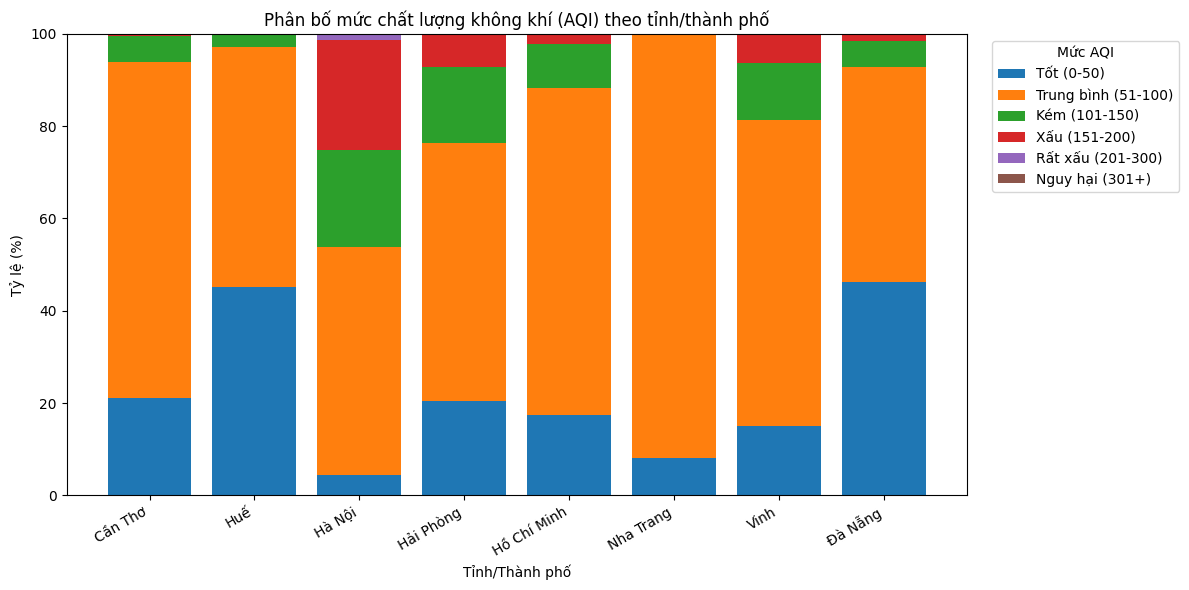

In [50]:
# Sắp thứ tự mức AQI cho đẹp
order_levels = ["Tốt (0-50)", "Trung bình (51-100)", "Kém (101-150)",
                "Xấu (151-200)", "Rất xấu (201-300)", "Nguy hại (301+)"]
distribution["AQI_level"] = pd.Categorical(distribution["AQI_level"],
                                           categories=order_levels, ordered=True)

# Pivot sang % để stack
pivot_pct = distribution.pivot(index="city", columns="AQI_level", values="percent").fillna(0)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
bottom = None
for lvl in order_levels:
    vals = pivot_pct[lvl] if lvl in pivot_pct.columns else 0
    plt.bar(pivot_pct.index, vals, bottom=bottom, label=lvl)
    bottom = (vals if bottom is None else bottom + vals)

plt.title("Phân bố mức chất lượng không khí (AQI) theo tỉnh/thành phố")
plt.ylabel("Tỷ lệ (%)")
plt.xlabel("Tỉnh/Thành phố")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Mức AQI", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


# 3. MỐI QUAN HỆ GIỮA AQI VÀ CÁC YẾU TỐ THỜI TIẾT
# 3.1 Tương quan giữa AQI và tốc độ gió (Wind Speed)
Mục tiêu phân tích:

Xét mối liên hệ giữa tốc độ gió và AQI nhằm kiểm tra giả thuyết:

“Gió mạnh có thể giúp phân tán bụi mịn và khí thải, từ đó cải thiện chất lượng không khí.”

In [51]:
import numpy as np
import pandas as pd

df_corr = df_corr.copy()  # nếu bạn đang có df_corr từ bước load có wind_speed

# Đảm bảo aqi là số
df_corr["aqi"] = pd.to_numeric(df_corr["aqi"], errors="coerce")

# Chuẩn hoá wind_speed → số km/h
# 1) về string
ws = df_corr["wind_speed"].astype(str)

# 2) thay dấu phẩy thập phân (nếu có) → chấm
ws = ws.str.replace(",", ".", regex=False)

# 3) loại bỏ mọi ký tự không phải số/âm/dấu chấm (bỏ " km/h", khoảng trắng, etc.)
ws = ws.str.replace(r"[^0-9\.\-]", "", regex=True)

# 4) chuyển sang float
df_corr["wind_speed_num"] = pd.to_numeric(ws, errors="coerce")

# Lọc chỉ giữ dòng hợp lệ cho tương quan
df_corr = df_corr.dropna(subset=["aqi", "wind_speed_num"]).reset_index(drop=True)

print("[i] Số dòng hợp lệ để tương quan:", len(df_corr))
print(df_corr[["city","aqi","wind_speed","wind_speed_num"]].head())


[i] Số dòng hợp lệ để tương quan: 35137
      city  aqi wind_speed  wind_speed_num
0  Cần Thơ   93   3.7 km/h             3.7
1  Cần Thơ   93   1.8 km/h             1.8
2  Cần Thơ   95   1.8 km/h             1.8
3  Cần Thơ   95   0.0 km/h             0.0
4  Cần Thơ   95   1.8 km/h             1.8


In [52]:
from scipy.stats import pearsonr, spearmanr

def safe_corr(x, y, method="pearson"):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = ~(np.isnan(x) | np.isnan(y))
    x = x[mask]; y = y[mask]
    if len(x) < 3:
        return np.nan, np.nan
    try:
        if method == "pearson":
            r, p = pearsonr(x, y)
        else:
            r, p = spearmanr(x, y)
        return float(r), float(p)
    except Exception:
        return np.nan, np.nan

rows = []
for city, g in df_corr.groupby("city"):
    r_p, p_p = safe_corr(g["aqi"], g["wind_speed_num"], method="pearson")
    r_s, p_s = safe_corr(g["aqi"], g["wind_speed_num"], method="spearman")
    rows.append({
        "city": city,
        "pearson_r": round(r_p, 4) if pd.notna(r_p) else np.nan,
        "pearson_p": p_p,
        "spearman_rho": round(r_s, 4) if pd.notna(r_s) else np.nan,
        "spearman_p": p_s,
        "n": len(g)
    })

# Tổng hợp tất cả
r_p_all, p_p_all = safe_corr(df_corr["aqi"], df_corr["wind_speed_num"], method="pearson")
r_s_all, p_s_all = safe_corr(df_corr["aqi"], df_corr["wind_speed_num"], method="spearman")
rows.append({
    "city": "__ALL__",
    "pearson_r": round(r_p_all, 4) if pd.notna(r_p_all) else np.nan,
    "pearson_p": p_p_all,
    "spearman_rho": round(r_s_all, 4) if pd.notna(r_s_all) else np.nan,
    "spearman_p": p_s_all,
    "n": len(df_corr)
})

corr_table = pd.DataFrame(rows).sort_values("city").reset_index(drop=True)

# Lưu
corr_csv = OUT_SUMMARY_DIR / "aqi_vs_windspeed_correlation.csv"
corr_table.to_csv(corr_csv, index=False, encoding="utf-8-sig")
print("[✓] Ghi:", corr_csv)
corr_table


[✓] Ghi: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\result_summary\aqi_vs_windspeed_correlation.csv


,city,pearson_r,pearson_p,spearman_rho,spearman_p,n
0,Cần Thơ,-0.3780,1.756673e-156,-0.4476,5.585117e-226,4609
1,Huế,-0.1917,2.419775e-39,-0.1681,1.629820e-30,4603
2,Hà Nội,-0.0486,2.011583e-03,-0.1082,5.354296e-12,4042
3,Hải Phòng,-0.2346,1.302759e-58,-0.2364,1.600765e-59,4604
4,Hồ Chí Minh,-0.2889,2.526902e-78,-0.3547,9.767452e-120,4029
5,Nha Trang,-0.0976,3.208269e-11,-0.1849,1.097536e-36,4605
6,Vinh,-0.1660,8.477748e-30,-0.2198,1.642568e-51,4606
7,__ALL__,-0.1111,7.378975e-97,-0.1584,4.357501e-196,35137
8,Đà Nẵng,-0.2561,1.682869e-61,-0.2564,1.178466e-61,4039


In [53]:
import matplotlib.pyplot as plt
import numpy as np

def linear_fit(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = ~(np.isnan(x) | np.isnan(y))
    x = x[mask]; y = y[mask]
    if len(x) < 2:
        return None, None
    a, b = np.polyfit(x, y, deg=1)
    return a, b

# --- Tất cả tỉnh
plt.figure(figsize=(8,6))
x = df_corr["wind_speed_num"].values
y = df_corr["aqi"].values
plt.scatter(x, y, alpha=0.4, s=15)
plt.title("Tương quan AQI vs Wind Speed (tất cả tỉnh)")
plt.xlabel("Wind Speed (km/h)")
plt.ylabel("AQI")

a, b = linear_fit(x, y)
if a is not None:
    xs = np.linspace(np.nanmin(x), np.nanmax(x), 100)
    ys = a*xs + b
    plt.plot(xs, ys)

plt.tight_layout()
out_all = OUT_PLOTS_DIR / "scatter_aqi_vs_windspeed_ALL.png"
plt.savefig(out_all, dpi=150)
plt.close()
print("[✓] Đã lưu:", out_all)

# --- Từng tỉnh
for city, g in df_corr.groupby("city"):
    plt.figure(figsize=(7,5))
    plt.scatter(g["wind_speed_num"], g["aqi"], alpha=0.5, s=15)
    plt.title(f"AQI vs Wind Speed – {city}")
    plt.xlabel("Wind Speed (km/h)")
    plt.ylabel("AQI")

    a, b = linear_fit(g["wind_speed_num"], g["aqi"])
    if a is not None:
        xs = np.linspace(np.nanmin(g["wind_speed_num"]), np.nanmax(g["wind_speed_num"]), 100)
        ys = a*xs + b
        plt.plot(xs, ys)

    plt.tight_layout()
    safe_city = str(city).replace("/", "_").replace("\\", "_").replace(":", "_")
    out_file = OUT_PLOTS_DIR / f"scatter_aqi_vs_windspeed_{safe_city}.png"
    plt.savefig(out_file, dpi=150)
    plt.close()
    print("[✓] Đã lưu:", out_file)


[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\scatter_aqi_vs_windspeed_ALL.png
[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\scatter_aqi_vs_windspeed_Cần Thơ.png
[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\scatter_aqi_vs_windspeed_Huế.png
[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\scatter_aqi_vs_windspeed_Hà Nội.png
[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\scatter_aqi_vs_windspeed_Hải Phòng.png
[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\scatter_aqi_vs_windspeed_Hồ Chí Minh.png
[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\scatter_aqi_vs_windspeed_Nha Trang.png
[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\scatter_aqi_vs_windspeed_Vinh.png
[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\scatter_aqi_vs_windspeed_Đà Nẵng.png


# 3.2 Tương quan giữa AQI và độ ẩm không khí (Humidity)
Mục tiêu phân tích:
Độ ẩm có ảnh hưởng đến khả năng giữ lại hoặc phát tán các hạt bụi mịn PM2.5. Mối quan hệ này có thể giúp cải thiện mô hình dự báo AQI theo mùa.

In [54]:
from pathlib import Path
import pandas as pd
import numpy as np

def load_all_cities_with_humidity(root: Path):
    dfs = []
    for city_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        for f in sorted(city_dir.glob("*.csv")):
            try:
                df = pd.read_csv(f)
            except Exception as e:
                print(f"[!] Lỗi đọc {f}: {e}")
                continue

            # chuẩn hoá tên cột
            if "AQI" in df.columns and "aqi" not in df.columns:
                df.rename(columns={"AQI":"aqi"}, inplace=True)

            need = {"timestamp","city","aqi","humidity"}
            if not need.issubset(df.columns):
                continue  # bỏ qua file thiếu cột

            # chuyển kiểu
            df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
            df["aqi"] = pd.to_numeric(df["aqi"], errors="coerce")

            dfs.append(df[["timestamp","city","aqi","humidity"]])
    if not dfs:
        raise RuntimeError("Không tìm thấy dữ liệu hợp lệ có cột humidity.")
    return pd.concat(dfs, ignore_index=True)

# --- chạy lại
DATA_DIR = Path("../data").resolve()
df_corr_hum = load_all_cities_with_humidity(DATA_DIR)
print(df_corr_hum.head())


                         timestamp     city  aqi humidity
0 2025-04-01 00:02:42.149853+07:00  Cần Thơ   93      94%
1 2025-04-01 01:02:11.555026+07:00  Cần Thơ   93      94%
2 2025-04-01 02:01:58.289887+07:00  Cần Thơ   95      94%
3 2025-04-01 03:02:14.527562+07:00  Cần Thơ   95      94%
4 2025-04-01 04:02:18.182428+07:00  Cần Thơ   95      94%


In [55]:
def parse_humidity(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip().replace("%", "").replace(",", ".")
    try:
        return float(s)
    except:
        return np.nan

df_corr_hum["humidity_num"] = df_corr_hum["humidity"].apply(parse_humidity)

# lọc hợp lệ
df_corr_hum = df_corr_hum.dropna(subset=["aqi","humidity_num"]).reset_index(drop=True)
print("[i] Số dòng hợp lệ:", len(df_corr_hum))
print(df_corr_hum[["city","aqi","humidity","humidity_num"]].head())


[i] Số dòng hợp lệ: 35137
      city  aqi humidity  humidity_num
0  Cần Thơ   93      94%          94.0
1  Cần Thơ   93      94%          94.0
2  Cần Thơ   95      94%          94.0
3  Cần Thơ   95      94%          94.0
4  Cần Thơ   95      94%          94.0


In [56]:
from scipy.stats import pearsonr, spearmanr

def safe_corr(x, y, method="pearson"):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = ~(np.isnan(x) | np.isnan(y))
    x = x[mask]; y = y[mask]
    if len(x) < 3:
        return np.nan, np.nan
    try:
        return pearsonr(x, y) if method=="pearson" else spearmanr(x, y)
    except Exception:
        return np.nan, np.nan

rows = []
for city, g in df_corr_hum.groupby("city"):
    r_p, p_p = safe_corr(g["aqi"], g["humidity_num"], method="pearson")
    r_s, p_s = safe_corr(g["aqi"], g["humidity_num"], method="spearman")
    rows.append({
        "city": city,
        "pearson_r": round(r_p, 4) if pd.notna(r_p) else np.nan,
        "pearson_p": p_p,
        "spearman_rho": round(r_s, 4) if pd.notna(r_s) else np.nan,
        "spearman_p": p_s,
        "n": len(g)
    })

# Toàn bộ
r_p_all, p_p_all = safe_corr(df_corr_hum["aqi"], df_corr_hum["humidity_num"], "pearson")
r_s_all, p_s_all = safe_corr(df_corr_hum["aqi"], df_corr_hum["humidity_num"], "spearman")
rows.append({
    "city": "__ALL__",
    "pearson_r": round(r_p_all, 4),
    "pearson_p": p_p_all,
    "spearman_rho": round(r_s_all, 4),
    "spearman_p": p_s_all,
    "n": len(df_corr_hum)
})

corr_hum_table = pd.DataFrame(rows).sort_values("city").reset_index(drop=True)

# Lưu kết quả
hum_corr_csv = OUT_SUMMARY_DIR / "aqi_vs_humidity_correlation.csv"
corr_hum_table.to_csv(hum_corr_csv, index=False, encoding="utf-8-sig")
print("[✓] Ghi:", hum_corr_csv)

corr_hum_table


[✓] Ghi: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\result_summary\aqi_vs_humidity_correlation.csv


,city,pearson_r,pearson_p,spearman_rho,spearman_p,n
0,Cần Thơ,0.0569,1.103748e-04,0.0685,3.267940e-06,4609
1,Huế,0.1123,2.190304e-14,0.0992,1.526041e-11,4603
2,Hà Nội,-0.1080,5.912520e-12,-0.1133,4.980040e-13,4042
3,Hải Phòng,-0.0172,2.439637e-01,-0.0101,4.951909e-01,4604
4,Hồ Chí Minh,-0.1327,2.740831e-17,-0.0923,4.344597e-09,4029
5,Nha Trang,-0.0295,4.502738e-02,0.1236,3.759102e-17,4605
6,Vinh,-0.0026,8.623998e-01,0.0156,2.894955e-01,4606
7,__ALL__,-0.0390,2.452275e-13,0.0110,3.951479e-02,35137
8,Đà Nẵng,0.1326,2.674745e-17,0.1031,5.081254e-11,4039


In [57]:
import matplotlib.pyplot as plt

def linear_fit(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = ~(np.isnan(x) | np.isnan(y))
    x = x[mask]; y = y[mask]
    if len(x) < 2:
        return None, None
    a, b = np.polyfit(x, y, deg=1)
    return a, b

# --- Tổng hợp tất cả tỉnh
plt.figure(figsize=(8,6))
x = df_corr_hum["humidity_num"].values
y = df_corr_hum["aqi"].values
plt.scatter(x, y, alpha=0.4, s=15)
plt.title("Tương quan AQI vs Humidity (tất cả tỉnh)")
plt.xlabel("Humidity (%)")
plt.ylabel("AQI")

a, b = linear_fit(x, y)
if a is not None:
    xs = np.linspace(np.nanmin(x), np.nanmax(x), 100)
    ys = a*xs + b
    plt.plot(xs, ys, color="red")

plt.tight_layout()
out_all = OUT_PLOTS_DIR / "scatter_aqi_vs_humidity_ALL.png"
plt.savefig(out_all, dpi=150)
plt.close()
print("[✓] Đã lưu:", out_all)

# --- Từng tỉnh
for city, g in df_corr_hum.groupby("city"):
    plt.figure(figsize=(7,5))
    plt.scatter(g["humidity_num"], g["aqi"], alpha=0.5, s=15)
    plt.title(f"AQI vs Humidity – {city}")
    plt.xlabel("Humidity (%)")
    plt.ylabel("AQI")

    a, b = linear_fit(g["humidity_num"], g["aqi"])
    if a is not None:
        xs = np.linspace(np.nanmin(g["humidity_num"]), np.nanmax(g["humidity_num"]), 100)
        ys = a*xs + b
        plt.plot(xs, ys, color="red")

    plt.tight_layout()
    safe_city = str(city).replace("/", "_").replace("\\", "_").replace(":", "_")
    out_file = OUT_PLOTS_DIR / f"scatter_aqi_vs_humidity_{safe_city}.png"
    plt.savefig(out_file, dpi=150)
    plt.close()
    print("[✓] Đã lưu:", out_file)


[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\scatter_aqi_vs_humidity_ALL.png
[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\scatter_aqi_vs_humidity_Cần Thơ.png
[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\scatter_aqi_vs_humidity_Huế.png
[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\scatter_aqi_vs_humidity_Hà Nội.png
[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\scatter_aqi_vs_humidity_Hải Phòng.png
[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\scatter_aqi_vs_humidity_Hồ Chí Minh.png
[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\scatter_aqi_vs_humidity_Nha Trang.png
[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\scatter_aqi_vs_humidity_Vinh.png
[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\scatter_aqi_vs_humidity_Đà Nẵng.png


# 4. AQI TRUNG BÌNH THEO LOẠI THỜI TIẾT VÀ TỈNH/THÀNH PHỐ

In [58]:
def map_weather_icon(icon_path: str) -> str:
    if pd.isna(icon_path):
        return "Unknown"
    icon_path = str(icon_path).lower()
    if "rain" in icon_path:
        return "Mưa"
    elif "cloud" in icon_path:
        return "Mây"
    elif "sun" in icon_path or "clear" in icon_path:
        return "Nắng"
    elif "fog" in icon_path or "mist" in icon_path:
        return "Sương mù"
    elif "storm" in icon_path or "thunder" in icon_path:
        return "Dông bão"
    elif "snow" in icon_path:
        return "Tuyết"
    else:
        return "Khác"


In [59]:
from pathlib import Path
import pandas as pd

def load_all_cities_with_weather(root: Path):
    dfs = []
    for city_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        for f in sorted(city_dir.glob("*.csv")):
            try:
                df = pd.read_csv(f)
            except Exception as e:
                print(f"[!] Lỗi đọc {f}: {e}")
                continue

            if "AQI" in df.columns and "aqi" not in df.columns:
                df.rename(columns={"AQI":"aqi"}, inplace=True)

            need = {"timestamp","city","aqi","weather_icon"}
            if not need.issubset(df.columns):
                continue

            df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
            df["aqi"] = pd.to_numeric(df["aqi"], errors="coerce")

            dfs.append(df[["timestamp","city","aqi","weather_icon"]])
    if not dfs:
        raise RuntimeError("Không tìm thấy dữ liệu hợp lệ có weather_icon.")
    return pd.concat(dfs, ignore_index=True)

# --- chạy
DATA_DIR = Path("../data").resolve()
df_weather = load_all_cities_with_weather(DATA_DIR)
print(df_weather.head())


                         timestamp     city  aqi  \
0 2025-04-01 00:02:42.149853+07:00  Cần Thơ   93   
1 2025-04-01 01:02:11.555026+07:00  Cần Thơ   93   
2 2025-04-01 02:01:58.289887+07:00  Cần Thơ   95   
3 2025-04-01 03:02:14.527562+07:00  Cần Thơ   95   
4 2025-04-01 04:02:18.182428+07:00  Cần Thơ   95   

                                        weather_icon  
0  /dl/web/weather/ic-w-04-scattered-clouds-full.svg  
1        /dl/web/weather/ic-w-12-night-rain-full.svg  
2        /dl/web/weather/ic-w-12-night-rain-full.svg  
3  /dl/web/weather/ic-w-04-scattered-clouds-full.svg  
4  /dl/web/weather/ic-w-04-scattered-clouds-full.svg  


In [60]:
df_weather["weather_type"] = df_weather["weather_icon"].apply(map_weather_icon)

# nhóm theo city × weather_type
weather_stats = (
    df_weather.groupby(["city","weather_type"])["aqi"]
              .mean()
              .reset_index()
              .rename(columns={"aqi":"mean_aqi"})
)
weather_stats["mean_aqi"] = weather_stats["mean_aqi"].round(2)

# Lưu CSV
out_csv = OUT_SUMMARY_DIR / "aqi_by_weather_and_city.csv"
weather_stats.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("[✓] Ghi:", out_csv)

print(weather_stats.head(20).to_string(index=False))


[✓] Ghi: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\result_summary\aqi_by_weather_and_city.csv
     city weather_type  mean_aqi
  Cần Thơ     Dông bão     64.04
  Cần Thơ         Khác     48.49
  Cần Thơ          Mây     67.18
  Cần Thơ          Mưa     48.91
  Cần Thơ         Nắng     75.62
  Cần Thơ     Sương mù     91.80
      Huế     Dông bão     49.47
      Huế         Khác     46.01
      Huế          Mây     56.67
      Huế          Mưa     51.77
      Huế         Nắng     50.41
      Huế     Sương mù     64.74
   Hà Nội         Khác     82.85
   Hà Nội          Mây    112.20
   Hà Nội          Mưa     83.15
   Hà Nội         Nắng    149.31
Hải Phòng     Dông bão     75.25
Hải Phòng         Khác     56.05
Hải Phòng          Mây     79.02
Hải Phòng          Mưa     62.70


In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# pivot để vẽ stacked/group bar
pivot = weather_stats.pivot(index="weather_type", columns="city", values="mean_aqi")

pivot.plot(kind="bar", figsize=(14,6))
plt.title("AQI trung bình theo loại thời tiết và tỉnh/thành phố")
plt.xlabel("Loại thời tiết")
plt.ylabel("AQI trung bình")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()

out_file = OUT_PLOTS_DIR / "aqi_by_weather_and_city.png"
plt.savefig(out_file, dpi=150)
plt.close()
print("[✓] Đã lưu:", out_file)


[✓] Đã lưu: C:\xampp\htdocs\Automatic-Anomaly-Detection-System\out\plots\aqi_by_weather_and_city.png


<Figure size 1200x600 with 0 Axes>